# Maxcut problem

## Setup

In [1]:
# General imports
import math
import numpy as np

# Qiskit ansatz circuits
from qiskit.circuit.library import TwoLocal

# Qiskit primitives
from qiskit.primitives import Estimator as QiskitEstimator
from qiskit.primitives import Sampler as QiskitSampler

# Qiskit runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session

# Qiskit optimization
from optimization import QuadraticProgram
from optimization.workflows import QuadraticConverter, QuadraticPostprocess

# translations
from optimization.translators import docplex_mp_to_qp
from optimization.translators import qubo_to_ising

# Docplex
from docplex.mp.model import Model

# SPSA
from spsa import minimize_spsa

# rustworkx graph library
import rustworkx as rs
from rustworkx.visualization import mpl_draw

## Load the Runtime (if using)

In [2]:
#service = QiskitRuntimeService()

In [3]:
#backend = service.get_backend('ibm_nazca')

## **Step 1**: Problem specification using standard tools and conversion to Quantum native format

Specify optimization problem using docplex and convert to Quadratic Unconstained Binary Opimization (QUBO) problem that can be cast as an Ising Hamiltonian suitable for a quantum solution.

In [4]:
def random_adjacency_graph(N, density=0.5):
    """Build random adjacency graph of a given density

    Parameters:
        N (int): Matrx dimension
        density (float): Density of non-zero elements, default=0.5

    Returns:
        ndarray: Adjacency matrix as NumPy array
    """
    off_elems = N*(N-1)//2
    num_elems = math.ceil(off_elems * density)
    inds = np.sort(np.random.choice(off_elems, size=num_elems, replace=False))

    M = np.zeros((N, N), dtype=float)
    for k in inds:
        i = N - 2 - int(math.sqrt(-8*k + 4*N*(N-1)-7)/2 - 0.5)
        j = (k + i + 1 - N*(N-1)//2 + (N-i)*((N-i)-1)//2)
        M[i,j] = 1

    M = M + M.T
    return M

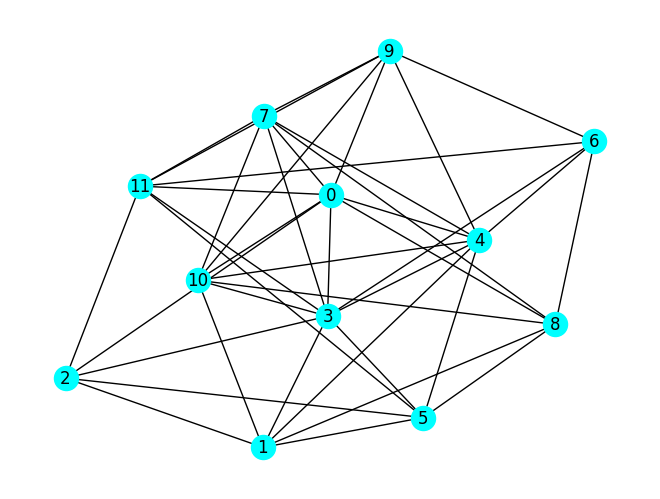

In [5]:
N = 12
density = 0.6
M = random_adjacency_graph(N, density)

G = rs.PyGraph.from_adjacency_matrix(M)
mpl_draw(G, with_labels=True, node_color='cyan')

In [6]:
mdl = Model(name="Max-cut")
x = {i: mdl.binary_var(name=f"x_{i}") for i in range(G.num_nodes())}
objective = mdl.sum(w * x[i] * (1 - x[j]) + w * x[j] * (1 - x[i]) for i, j, w in G.weighted_edge_list())
mdl.maximize(objective)
print(mdl.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Max-cut

Maximize
 obj: 8 x_0 + 6 x_1 + 5 x_2 + 9 x_3 + 8 x_4 + 6 x_5 + 5 x_6 + 7 x_7 + 6 x_8
      + 6 x_9 + 7 x_10 + 7 x_11 + [ - 4 x_0*x_2 - 4 x_0*x_3 - 4 x_0*x_4
      - 4 x_0*x_7 - 4 x_0*x_8 - 4 x_0*x_9 - 4 x_0*x_10 - 4 x_0*x_11 - 4 x_1*x_2
      - 4 x_1*x_3 - 4 x_1*x_4 - 4 x_1*x_5 - 4 x_1*x_8 - 4 x_1*x_10 - 4 x_2*x_3
      - 4 x_2*x_5 - 4 x_2*x_11 - 4 x_3*x_4 - 4 x_3*x_5 - 4 x_3*x_6 - 4 x_3*x_7
      - 4 x_3*x_10 - 4 x_3*x_11 - 4 x_4*x_5 - 4 x_4*x_6 - 4 x_4*x_7 - 4 x_4*x_9
      - 4 x_4*x_10 - 4 x_5*x_8 - 4 x_5*x_11 - 4 x_6*x_8 - 4 x_6*x_9 - 4 x_6*x_11
      - 4 x_7*x_8 - 4 x_7*x_9 - 4 x_7*x_10 - 4 x_7*x_11 - 4 x_8*x_10
      - 4 x_9*x_10 - 4 x_9*x_11 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1
 0 <= x_5 <= 1
 0 <= x_6 <= 1
 0 <= x_7 <= 1
 0 <= x_8 <= 1
 0 <= x_9 <= 1
 0 <= x_10 <= 1
 0 <= x_11 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8 x_9

### Convert to our `QuadraticProgram` format

In [7]:
qp = docplex_mp_to_qp(mdl)
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_10 - 2*x_0*x_11 - 2*x_0*x_2 - 2*x_0*x_3 - 2*x_0*x_4 - 2*x_0*x_7
  - 2*x_0*x_8 - 2*x_0*x_9 - 2*x_1*x_10 - 2*x_1*x_2 - 2*x_1*x_3 - 2*x_1*x_4
  - 2*x_1*x_5 - 2*x_1*x_8 - 2*x_2*x_11 - 2*x_2*x_3 - 2*x_2*x_5 - 2*x_3*x_10
  - 2*x_3*x_11 - 2*x_3*x_4 - 2*x_3*x_5 - 2*x_3*x_6 - 2*x_3*x_7 - 2*x_4*x_10
  - 2*x_4*x_5 - 2*x_4*x_6 - 2*x_4*x_7 - 2*x_4*x_9 - 2*x_5*x_11 - 2*x_5*x_8
  - 2*x_6*x_11 - 2*x_6*x_8 - 2*x_6*x_9 - 2*x_7*x_10 - 2*x_7*x_11 - 2*x_7*x_8
  - 2*x_7*x_9 - 2*x_8*x_10 - 2*x_9*x_10 - 2*x_9*x_11 + 8*x_0 + 6*x_1 + 7*x_10
  + 7*x_11 + 5*x_2 + 9*x_3 + 8*x_4 + 6*x_5 + 5*x_6 + 7*x_7 + 6*x_8 + 6*x_9

Subject to
  No constraints

  Binary variables (12)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8 x_9 x_10 x_11



### Classical transformation to QUBO problem and Ising Hamiltonian

In [8]:
quadratic_transformer = QuadraticConverter()
qubo = quadratic_transformer.run(qp)
print(qubo.prettyprint())

Problem name: Max-cut

Minimize
  2*x_0*x_10 + 2*x_0*x_11 + 2*x_0*x_2 + 2*x_0*x_3 + 2*x_0*x_4 + 2*x_0*x_7
  + 2*x_0*x_8 + 2*x_0*x_9 + 2*x_1*x_10 + 2*x_1*x_2 + 2*x_1*x_3 + 2*x_1*x_4
  + 2*x_1*x_5 + 2*x_1*x_8 + 2*x_2*x_11 + 2*x_2*x_3 + 2*x_2*x_5 + 2*x_3*x_10
  + 2*x_3*x_11 + 2*x_3*x_4 + 2*x_3*x_5 + 2*x_3*x_6 + 2*x_3*x_7 + 2*x_4*x_10
  + 2*x_4*x_5 + 2*x_4*x_6 + 2*x_4*x_7 + 2*x_4*x_9 + 2*x_5*x_11 + 2*x_5*x_8
  + 2*x_6*x_11 + 2*x_6*x_8 + 2*x_6*x_9 + 2*x_7*x_10 + 2*x_7*x_11 + 2*x_7*x_8
  + 2*x_7*x_9 + 2*x_8*x_10 + 2*x_9*x_10 + 2*x_9*x_11 - 8*x_0 - 6*x_1 - 7*x_10
  - 7*x_11 - 5*x_2 - 9*x_3 - 8*x_4 - 6*x_5 - 5*x_6 - 7*x_7 - 6*x_8 - 6*x_9

Subject to
  No constraints

  Binary variables (12)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8 x_9 x_10 x_11



In [9]:
hamiltonian, offset = qubo_to_ising(qubo)
hamiltonian

SparsePauliOp(['IIIIIIIIIZIZ', 'IIIIIIIIZIIZ', 'IIIIIIIZIIIZ', 'IIIIZIIIIIIZ', 'IIIZIIIIIIIZ', 'IIZIIIIIIIIZ', 'IZIIIIIIIIIZ', 'ZIIIIIIIIIIZ', 'IIIIIIIIIZZI', 'IIIIIIIIZIZI', 'IIIIIIIZIIZI', 'IIIIIIZIIIZI', 'IIIZIIIIIIZI', 'IZIIIIIIIIZI', 'IIIIIIIIZZII', 'IIIIIIZIIZII', 'ZIIIIIIIIZII', 'IIIIIIIZZIII', 'IIIIIIZIZIII', 'IIIIIZIIZIII', 'IIIIZIIIZIII', 'IZIIIIIIZIII', 'ZIIIIIIIZIII', 'IIIIIIZZIIII', 'IIIIIZIZIIII', 'IIIIZIIZIIII', 'IIZIIIIZIIII', 'IZIIIIIZIIII', 'IIIZIIZIIIII', 'ZIIIIIZIIIII', 'IIIZIZIIIIII', 'IIZIIZIIIIII', 'ZIIIIZIIIIII', 'IIIZZIIIIIII', 'IIZIZIIIIIII', 'IZIIZIIIIIII', 'ZIIIZIIIIIII', 'IZIZIIIIIIII', 'IZZIIIIIIIII', 'ZIZIIIIIIIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5

## **Step 2**: Setup quantum solution method and optimize

### Select ansatz circuit from circuit library

In [10]:
ansatz = TwoLocal(hamiltonian.num_qubits, 'ry', 'cx', 'linear', reps=2)

## **Step 3**: Solve using quantum primitives

### Standard cost function definition

In [11]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

### Setup estimator and sampler instances

In [12]:
#session = Session(backend=backend)
#estimator = Estimator(session=session, options={"shots": int(1e4)})
#sampler = Sampler(session=session, options={"shots": int(1e4)})
estimator = QiskitEstimator(options={"shots": int(1e4)})
sampler = QiskitSampler(options={"shots": int(1e4)})

### Perform minimization

In [13]:
x0 = 2*np.pi*np.random.random(size=ansatz.num_parameters)
res = minimize_spsa(cost_func, x0, args=(ansatz, hamiltonian, estimator), maxiter=150)
res

 message: Optimization terminated successfully.
 success: True
     fun: -4.285635469315967
       x: [ 2.782e+00  5.644e+00 ...  4.222e+00  6.311e+00]
     nit: 150
    nfev: 300

### Computute distribution at found minimum

In [14]:
# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(res.x)
qc.measure_all()
samp_dist = sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]
# Close the session since we are now done with it
#session.close()

## **Step 4**: Post-process and return answer in classical format
Transform quantum solution and convert back into classical variable space

In [15]:
solution =QuadraticPostprocess(qubo, quadratic_transformer).run(samp_dist)
solution

array([1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0.])

## Intepretation of solution

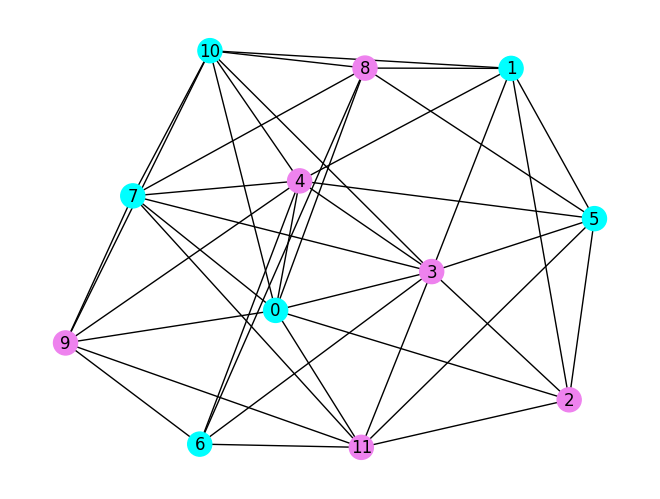

In [16]:
mpl_draw(G, with_labels=True, 
         node_color=['cyan' if kk else 'violet' for kk in solution])